In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from dask.distributed import Client

In [3]:
import cartopy.crs as ccrs

In [4]:
import numpy as np

In [5]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit=8e9, ip="0.0.0.0")
client

/opt/conda/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41297 instead
  warnings.warn(
2023-06-12 13:19:39,411 - distributed.diskutils - INFO - Found stale lock file and directory '/work/dask-worker-space/worker-u9wst4ns', purging
2023-06-12 13:19:39,419 - distributed.diskutils - INFO - Found stale lock file and directory '/work/dask-worker-space/worker-su0biwh8', purging
2023-06-12 13:19:39,425 - distributed.diskutils - INFO - Found stale lock file and directory '/work/dask-worker-space/worker-8wqjp9d0', purging
2023-06-12 13:19:39,431 - distributed.diskutils - INFO - Found stale lock file and directory '/work/dask-worker-space/worker-84th_5k1', purging


<Client: 'tcp://134.245.3.13:39257' processes=4 threads=8, memory=29.80 GiB>

In [6]:
data_path = '/gxfs_work1/geomar/smomw529/2022_north-sea_oysters/data/ocean/MetO-NWS-PHY-hi-CUR/'
data_filename = '????/??/*.nc'

lat_top = 62.74
lat_bottom = 46
lon_left = -16
lon_right = 13

In [7]:
data_path = Path(data_path)
files = list(sorted((data_path).glob(data_filename)))

In [8]:
ds = xr.open_mfdataset(files, chunks={"lon": 958, "lat": 1240, "time": 365, "depth": 3})

In [9]:
ds

<xarray.Dataset>
Dimensions:  (time: 31920, depth: 33, lat: 1240, lon: 958)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T01:00:00 ... 2022-08-23
  * lat      (lat) float32 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 -16.0 -15.97 -15.94 -15.91 ... 12.91 12.94 12.97 13.0
  * depth    (depth) float32 0.0 3.0 5.0 10.0 15.0 ... 2e+03 3e+03 4e+03 5e+03
Data variables:
    uo       (time, depth, lat, lon) float32 dask.array<chunksize=(24, 3, 1240, 958), meta=np.ndarray>
    vo       (time, depth, lat, lon) float32 dask.array<chunksize=(24, 3, 1240, 958), meta=np.ndarray>
Attributes: (12/13)
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    title:                hourly-instantaneous horizontal velocity (3D)
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    Conventions:          CF-1.7
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    ...                   ...
    netcdf-version-id:    netCDF-4
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    references:           http://marine.copernicus.eu/
    creation_date:        2020-09-29T11:14:47Z
    institution:          UK Met Office
    history:              See source and creation_date attributes

In [10]:
u = ds["uo"].sel(depth=slice(0, 10, None)).sel(time=slice('2021-07-15T00:00:00','2021-07-15T09:00:00'))
v = ds["vo"].sel(depth=slice(0, 10, None)).sel(time=slice('2021-07-15T00:00:00','2021-07-15T09:00:00'))

In [11]:
# english channel
u = u.sel(lon=slice(-4, 1, None), lat=slice(48.5, 51, None))
v = v.sel(lon=slice(-4, 1, None), lat=slice(48.5, 51, None))

In [12]:
vel = xr.combine_by_coords([u, v], compat='override', combine_attrs='drop_conflicts')

In [13]:
vel["vel"] = np.sqrt(vel.uo**2 + vel.vo**2)

In [14]:
vel = vel.compute()

In [15]:
vel

<xarray.Dataset>
Dimensions:  (time: 10, lat: 186, lon: 166, depth: 4)
Coordinates:
  * time     (time) datetime64[ns] 2021-07-15 ... 2021-07-15T09:00:00
  * lat      (lat) float32 48.5 48.51 48.53 48.54 ... 50.96 50.97 50.99 51.0
  * lon      (lon) float32 -4.0 -3.97 -3.939 -3.909 ... 0.9091 0.9394 0.9697 1.0
  * depth    (depth) float32 0.0 3.0 5.0 10.0
Data variables:
    uo       (time, depth, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    vo       (time, depth, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    vel      (time, depth, lat, lon) float32 nan nan nan nan ... nan nan nan nan

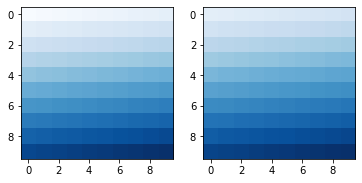

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap, 0.1, 1)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [17]:
plt.rcParams.update({'font.size': 18})

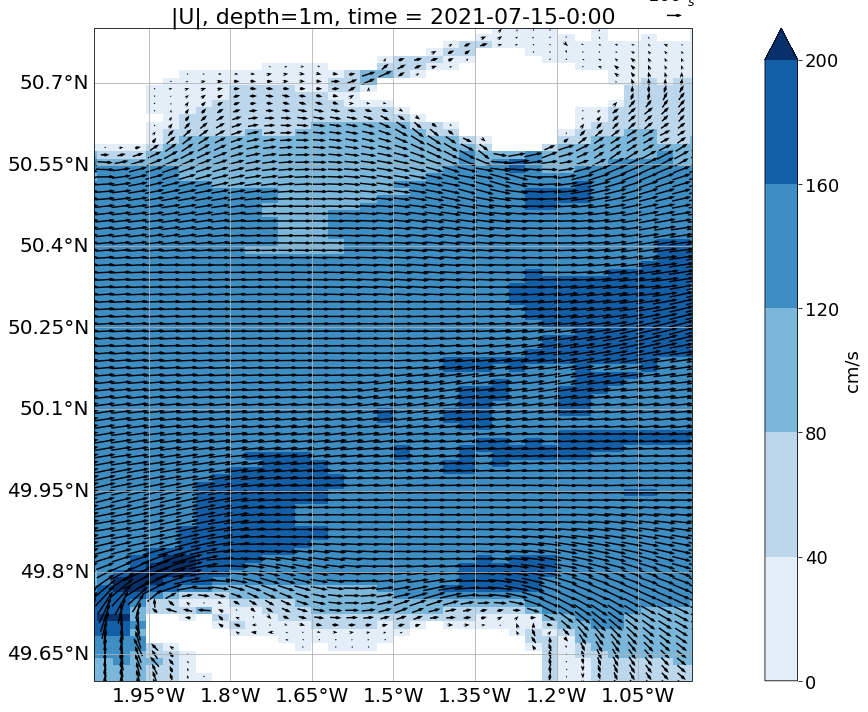

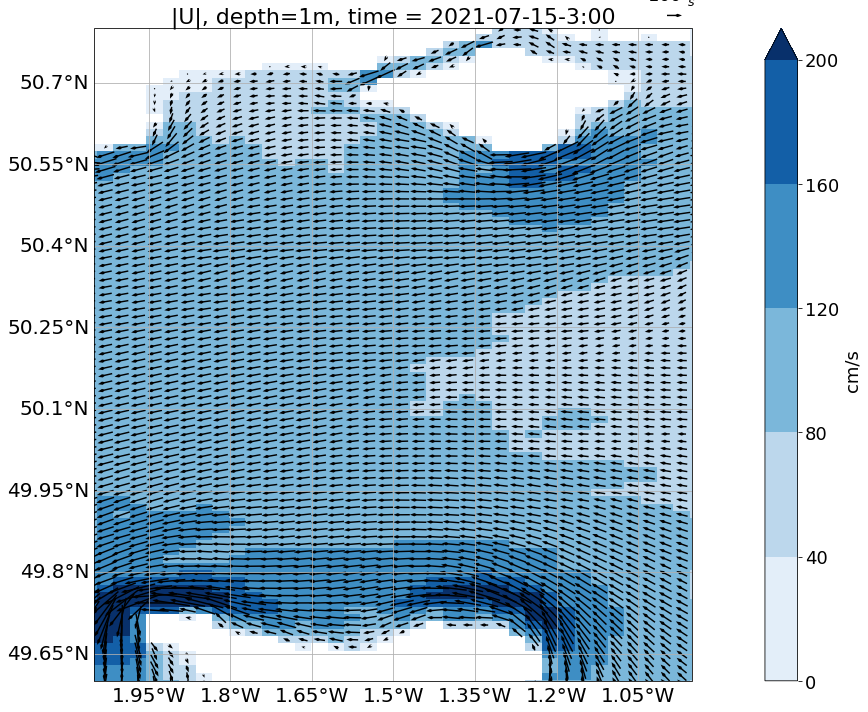

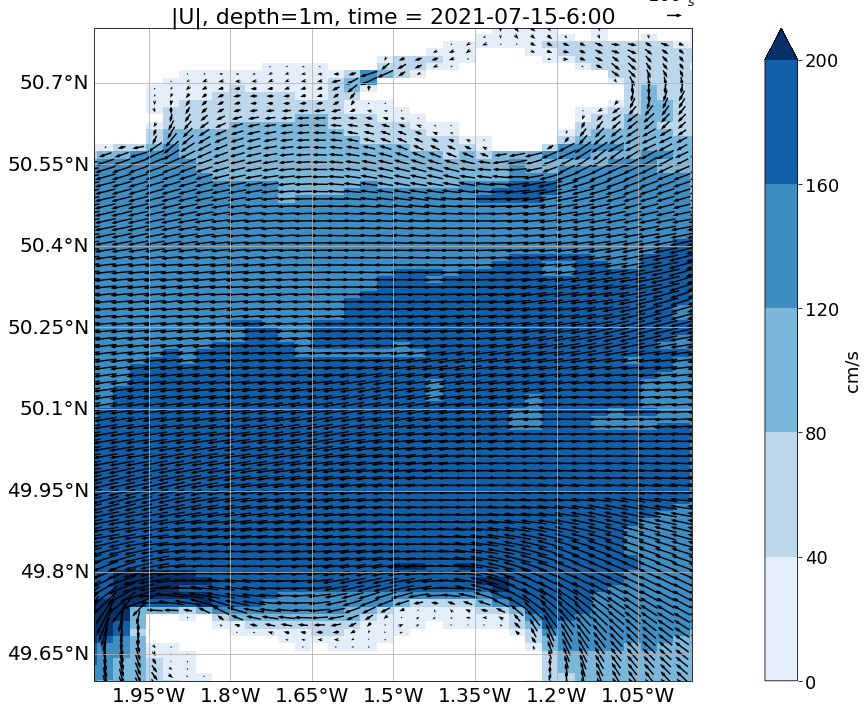

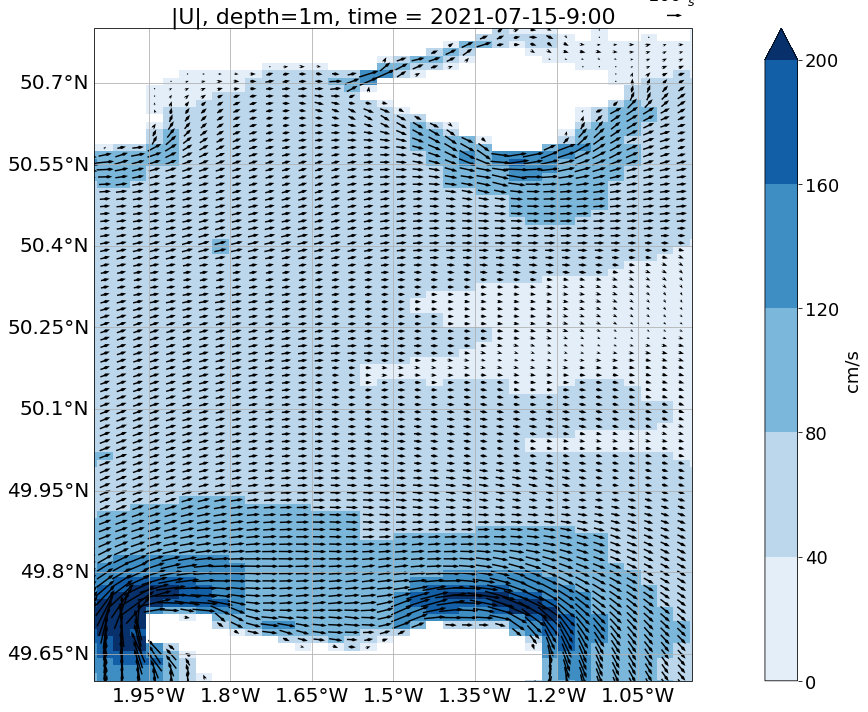

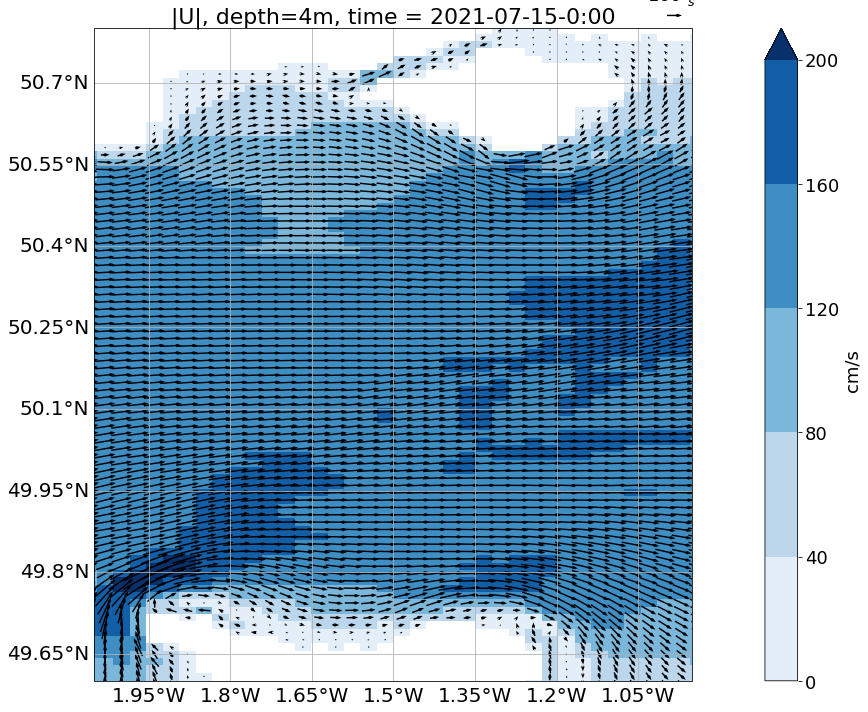

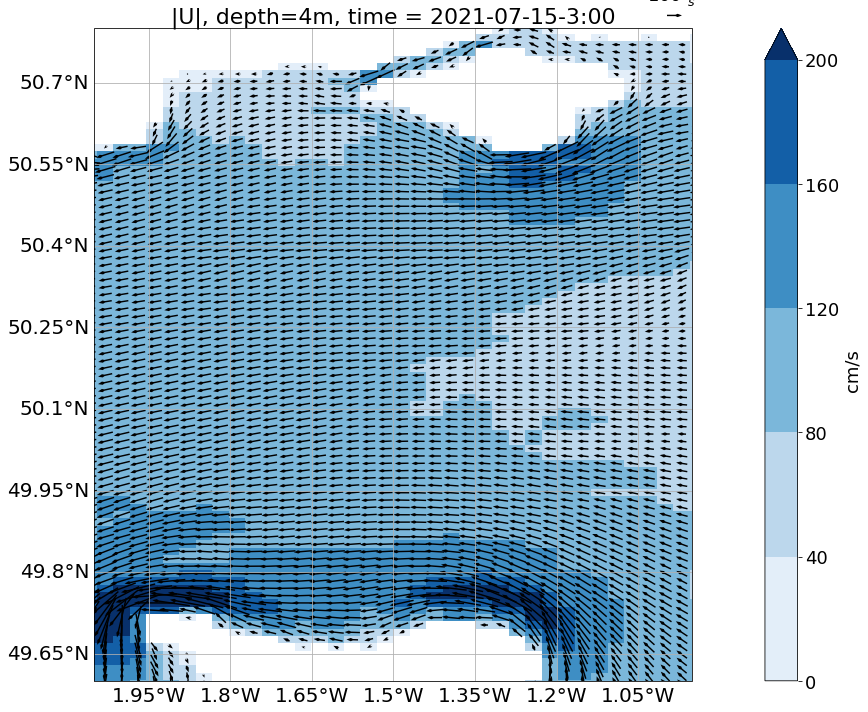

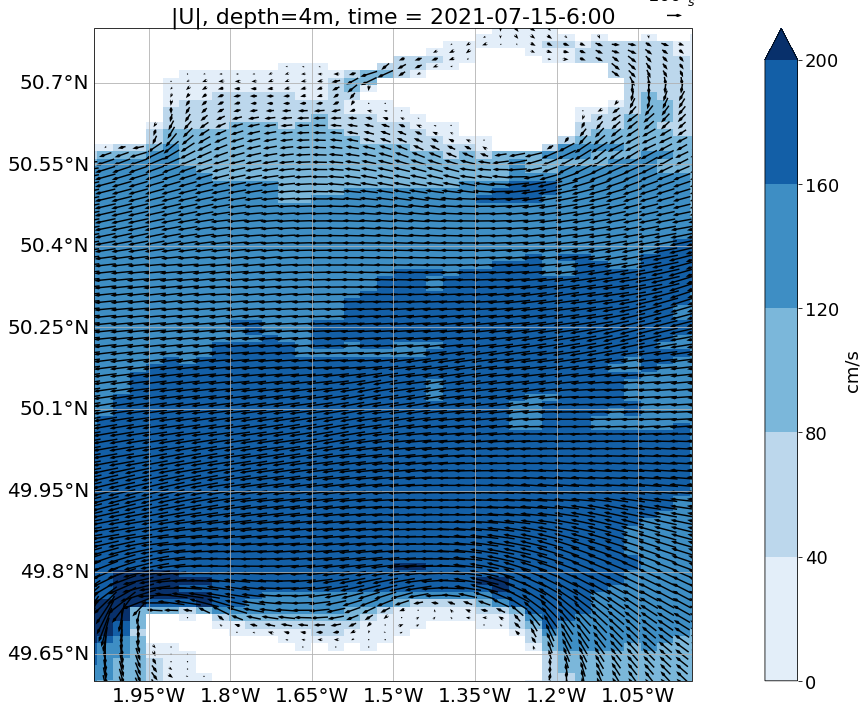

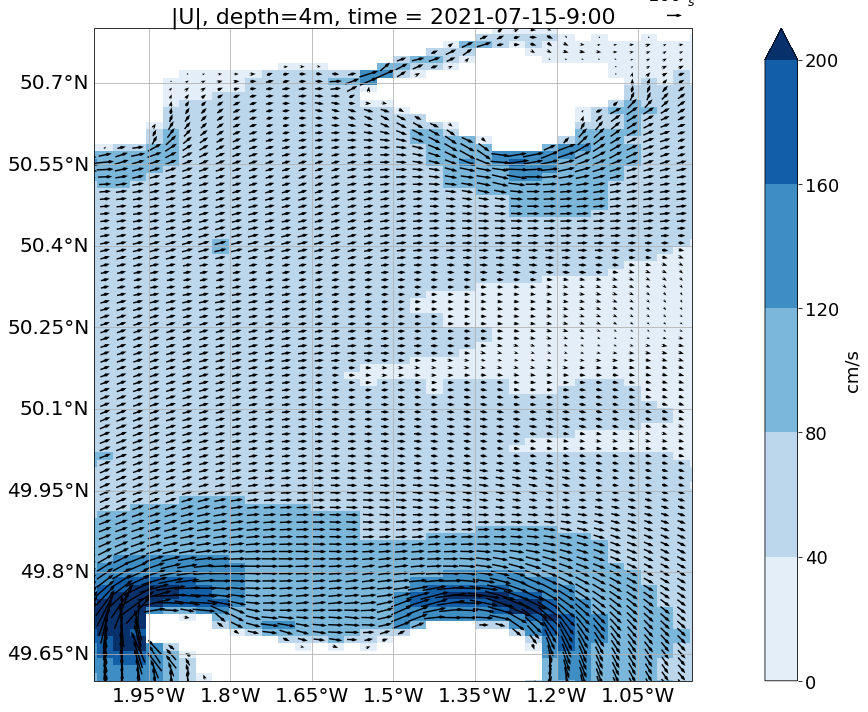

In [19]:
for i, depth in enumerate([1, 4]):
    for j in [0,3,6,9]:
        fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,
                               subplot_kw={"projection": ccrs.PlateCarree()},
                               figsize=(26, 12),
                              )
        (vel["vel"]*100).isel(depth=i, time=j).plot(#.where(mask==1)
        ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", levels=np.linspace(0, 200, 6),
        cmap=new_cmap, cbar_kwargs={"label": "cm/s"}, vmax=150
        )
        q = vel.where(vel["vel"] > 0).isel(depth=i, lon=slice(None, None, 1),
                                           lat=slice(None, None, 1), time=j).plot.quiver(
            ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", u="uo", v="vo", scale=40, color="black",
            add_guide=True, linewidths=0.1, headwidth=2.3, headlength= 3
            )
        ax.quiverkey(q, 0.97, 1.02, 1, r'$100 \frac{cm}{s}$', coordinates='axes')
        ax.set_extent([-2.05, -0.95, 49.6, 50.8], crs=ccrs.PlateCarree())
        gl = ax.gridlines(draw_labels=["bottom", "left"], xlabel_style={"size": 20}, ylabel_style={"size": 20});

        ax.set_title(f"|U|, depth={depth}m, time = 2021-07-15-{j}:00".format(depth=depth), size=22);
        fig
    
        plt.savefig(f"english-channel_tides_{depth}m_2021-07-15-{j}:00.png".format(depth=depth), dpi=300)